# Flysight GPS

![Drag Racing](../img/product.jpg)

**FlySight is not your mother's GPS.**

FlySight was designed from the ground up for wingsuit pilots and does one truly revolutionary thing...

**FlySight provides real-time audible indication of glide ratio, horizontal or vertical speed.**

If you've used other GPS receivers, you know the drill. When you land, you review data from the jump. If you're lucky, or if you've planned a very simple jump, you might remember what you were doing when your glide ratio maxed out. On the next jump, you try to do it again.

**FlySight speeds the learning process.**

When you change your body position, you instantly hear a change in the tone. Your brain easily connects this feedback with your precise body position, making it astonishingly easy to remember what worked and what didn't.

### Data produced

https://www.monocilindro.com/wp-content/uploads/2016/03/u-blox6-Receiver-Description-Protocol-Specification.pdf
https://www.monocilindro.com/2017/02/22/gps-data-logger-using-arduino-unonano-and-ublox-neo-6m/


| Data   | Unity  | Meaning                                |
| :----- | :----- | :------------------------------------- |
| time   | object | time                                   |
| lat    | deg    | latitude                               |
| lon    | deg    | longitude                              |
| hMSL   | m      | Height Above sea level                 |
| velN   | m/s    | NED north velocity                     |
| velE   | m/s    | NED east velocity                      |
| velD   | m/s    | NED down velocity                      |
| hAcc   | m      | Horizontal Accuracy Estimate           |
| vAcc   | m      | Vertical Accuracy Estimate             |
| sAcc   | m/s    | Speed Accuracy Estimate                |
| gpsFix |        | Position Fix Flags in NMEA MODE        |
| numSV  |        | Number of per-SV data blocks following |

### Imports

In [82]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import plotly.express as px
import datetime as dt
from math import radians, cos, sin, asin, sqrt, degrees, atan
import requests
import urllib
import itertools
import time
import peakutils as pu

In [83]:
# inlezen van de dataset
data = pd.read_csv('../data/J1.csv', skiprows=[1])
data.head()

,time,lat,lon,hMSL,velN,velE,velD,hAcc,vAcc,sAcc,heading,cAcc,gpsFix,numSV
0,2022-06-22T11:45:46.80Z,56.183217,9.040273,-22.772,2.44,-0.89,-4.79,174.336,295.980,7.29,340.00856,35.79024,3,6
1,2022-06-22T11:45:47.00Z,56.183230,9.040298,-22.027,1.85,-0.27,-1.84,103.671,152.919,3.80,344.61396,44.06033,3,5
2,2022-06-22T11:45:47.20Z,56.183236,9.040297,-24.504,1.73,-0.93,-1.26,107.556,163.691,3.75,335.28268,27.61818,3,4
3,2022-06-22T11:45:47.40Z,56.183298,9.040240,-18.407,0.90,-0.70,-1.05,90.334,140.775,3.19,335.28268,27.62859,3,6
4,2022-06-22T11:45:47.60Z,56.183349,9.040209,-10.147,0.21,-0.13,-0.86,74.252,119.369,2.77,335.28268,27.63762,3,5


In [94]:
# Helper functions

def meters_to_feet(meters):
    return meters * 3.280839895

def feet_to_meters(feet):
    return feet / 3.280839895

def meterpersecond_to_milesperhour(meterpersecond):
    return meterpersecond * 2.236936

def meterpersecond_to_kilometersperhour(meterpersecond):
    return meterpersecond * 3.6

def calc_horizontal_speed(n, e):
    return sqrt((n**2) + (e**2))

def calc_dive_angle(v_speed, h_speed):
    try:
        return degrees(atan(v_speed/h_speed))
    except ZeroDivisionError:
        return 0   
    
def calc_distance(lat1, lat2, lon1, lon2):
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
        
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    
    c = 2 * asin(sqrt(a))
        
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
    
    # calculate the result
    return meters_to_feet((c * r) * 1000)

In [89]:
# Trash functions

def divide_dataset(l, n):
        for i in range(0, len(l), n):
            yield l[i:i + n]

def request_earth_elevation(x):
    s = "https://api.open-elevation.com/api/v1/lookup?locations="
    for i in range(x.index.start, x.index.stop): 
        s += str(x.lat[i]) + "," + str(x.lon[i]) + "|"
    r = requests.get(s[:-1])  
    if r.status_code == 200:
        elevation = pd.json_normalize(r.json(), 'results')['elevation']
        return elevation
    else:
        print(r)
        
def get_earth_elevation():
    l = []
    divided_dataset = list(divide_dataset(dataset, 120))
    for i in range(0, len(divided_dataset)):
        l.append(request_earth_elevation(divided_dataset[i]).values)
        time.sleep(0.07)
    return list(itertools.chain(*l))

def get_dynamic_elevation():
    ground_elevation = meters_to_feet(dataset.hMSL.iloc[-1])
    earth_elevation = [meters_to_feet(e) for e in get_earth_elevation()]
    l = []
    for i in range(0, len(dataset.hMSL)):
        l.append(meters_to_feet(dataset.hMSL[i]) - ground_elevation - earth_elevation[i])
    return l

In [95]:
# Dataset

class Dataset:
    def __init__(self, name, df):
        self.name = name
        self.old_df = df 
        self.df = self.update_df()
        
    def get_total_seconds(self):
        datetimes = [pd.to_datetime(d) for d in self.old_df.time]
        l = []
        for i, d in enumerate(datetimes):
            duration = datetimes[i] - datetimes[0]
            l.append(duration.total_seconds())
        return l

    def get_fixed_elevation(self, elevation):
        ground_elevation = meters_to_feet(self.old_df.hMSL.iloc[-1])
        return [meters_to_feet(self.old_df.hMSL[i]) - ground_elevation - elevation for i in range(0, len(self.old_df.hMSL))]

    def get_vertical_speed(self, metric):
        if metric == 'mph':
            return [meterpersecond_to_milesperhour(meter) for meter in self.old_df.velD]
        elif metric == 'km/u':
            return [meterpersecond_to_kilometersperhour(meter) for meter in self.old_df.velD]
        else:
            raise ValueError('Invalid metric')

    def get_horizontal_speed(self, metric):
        speed = [calc_horizontal_speed(self.old_df.velN[i], self.old_df.velE[i]) for i in range(0, len(self.old_df))]
        if metric == 'mph':
            return [meterpersecond_to_milesperhour(s) for s in speed]
        elif metric == 'km/u':
            return [meterpersecond_to_kilometersperhour(s) for s in speed]
        else:
            raise ValueError('Invalid metric')

    def get_dive_angle(self, v_speed, h_speed):
        return [calc_dive_angle(v_speed[i], h_speed[i]) for i in range(0, len(self.old_df))]

    def get_horizontal_distance(self):
        l, f = [0], 0.0
        for i in range(0, len(self.old_df)-1):
            f += calc_distance(self.old_df.lat[i], self.old_df.lat[i+1], self.old_df.lon[i], self.old_df.lon[i+1])
            l.append(f)
        return l

    def update_df(self):
        return pd.DataFrame({
            'time': np.array(self.get_total_seconds()),
            'lat': self.old_df.lat,
            'lon': self.old_df.lon,
            'elevation': self.get_fixed_elevation(0),
            'horz_distance': self.get_horizontal_distance(),
            'vert_speed_mph': self.get_vertical_speed('mph'),
            'horz_speed_mph': self.get_horizontal_speed('mph'),
            'vert_speed_km': self.get_vertical_speed('km/u'),
            'horz_speed_km': self.get_horizontal_speed('km/u'),
            'dive_angle': self.get_dive_angle(self.get_vertical_speed('mph'), self.get_horizontal_speed('mph'))})
    
    def copy(self):
        self.df.to_csv(f'.\\data\\test-v1-{self.name}')

    def get_df(self):
        return self.df

    def __str__ (self):
            return f'{self.name}'

In [96]:
df = Dataset("flysight_v1", data).get_df()
df.head(10)

,time,lat,lon,elevation,horz_distance,vert_speed_mph,horz_speed_mph,vert_speed_km,horz_speed_km,dive_angle
0,0.0,56.183217,9.040273,-207.821522,0.000000,-10.714923,5.809879,-17.244,9.350095,-61.532429
1,0.2,56.183230,9.040298,-205.377297,7.076375,-4.115962,4.182173,-6.624,6.730556,-44.542847
2,0.4,56.183236,9.040297,-213.503937,9.125773,-2.818539,4.393629,-4.536,7.070862,-32.680413
3,0.6,56.183298,9.040240,-193.500656,34.686239,-2.348783,2.550499,-3.780,4.104632,-42.642310
4,0.8,56.183349,9.040209,-166.400919,54.349058,-1.923765,0.552482,-3.096,0.889134,-73.976563
5,1.0,56.183423,9.040161,-130.810367,82.790887,-2.438260,0.368925,-3.924,0.593727,-81.396032
6,1.2,56.183453,9.040129,-121.167979,95.518914,-2.661954,0.360695,-4.284,0.580483,-82.283412
7,1.4,56.183477,9.040107,-110.682415,105.334909,-2.706693,0.364147,-4.356,0.586038,-82.337680
8,1.6,56.183490,9.040096,-102.923228,110.868640,-2.125089,1.449873,-3.420,2.333344,-55.695672
9,1.8,56.183485,9.040088,-107.326115,113.410484,-1.968504,1.202548,-3.168,1.935314,-58.579470


In [109]:
# Change point of time

def change_point(key):
    k = df.iloc[:key].time
    k = k.iloc[::-1].reset_index()
    print(k)
    
change_point(20)

    index  time
0      19   3.8
1      18   3.6
2      17   3.4
3      16   3.2
4      15   3.0
5      14   2.8
6      13   2.6
7      12   2.4
8      11   2.2
9      10   2.0
10      9   1.8
11      8   1.6
12      7   1.4
13      6   1.2
14      5   1.0
15      4   0.8
16      3   0.6
17      2   0.4
18      1   0.2
19      0   0.0


### Set start of skydive

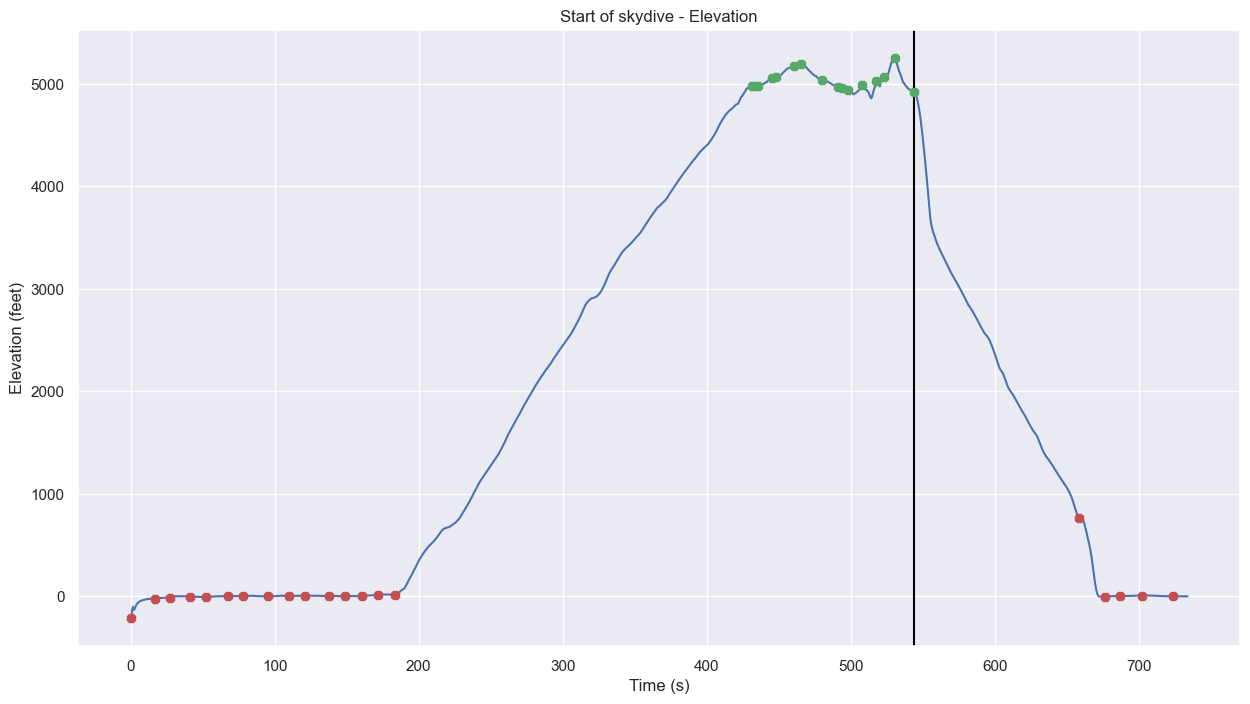

key: 2719 ; time(s): 543.8


In [93]:
def get_peaks(y, thres, min_dist):
    return pu.indexes(y, thres=thres, min_dist=min_dist)
    
def get_lows(y, thres, min_dist):
    return pu.indexes(y * -1, thres=thres, min_dist=min_dist) 

def start_skydive_elevation():
    return get_peaks(df.elevation, 0.9, 50)[-1]

def plt_start_skydive_elevation(x, y):
    peaks = get_peaks(y, 0.5, 10)
    lows = get_lows(y, 0.15, 50)
    
    plt.figure(figsize=(15,8))    
    plt.plot(x, y)
    plt.axvline(x = x[peaks[-1]], color = 'black', label = 'axvline - full height')
    plt.plot(x[peaks], y[peaks], marker="8", color='g', ls="")
    plt.plot(x[lows], y[lows], marker="8", color='r', ls="")
    plt.title("Start of skydive - Elevation")
    plt.xlabel("Time (s)")
    plt.ylabel("Elevation (feet)")
    plt.show()
    
    print(f'key: {peaks[-1]} ; time(s): {x[peaks[-1]]}')
    
# dataframe start skydive
jmp_df = df.iloc[start_skydive_elevation():]
jmp_df = jmp_df.reset_index()

test_df = df.iloc[2400:]
test_df = test_df.reset_index()
plt_start_skydive_elevation(df.time, df.elevation)

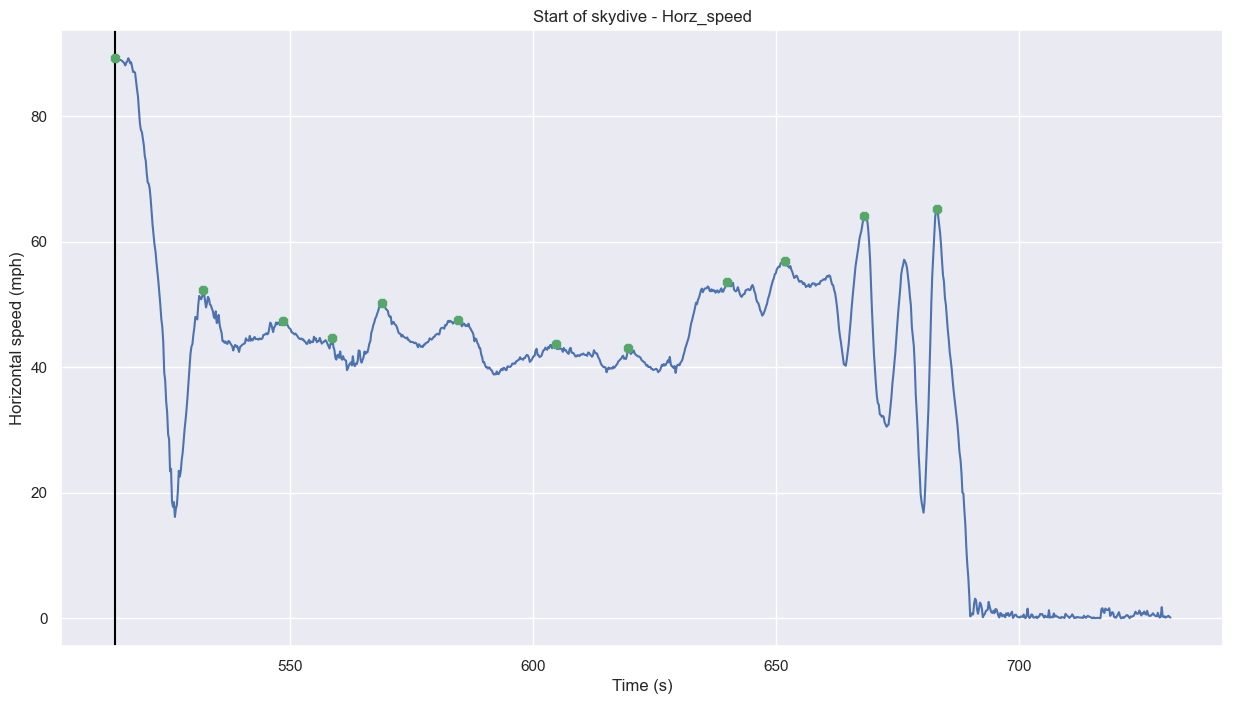

key: 1 ; time(s): 514.0


In [80]:
def start_skydive_horz_speed(x, y):
    peaks = get_peaks(y, 0.15, 50)
    lows = get_lows(y, 0.15, 10)
    
    plt.figure(figsize=(15,8))    
    plt.plot(x, y)
    plt.axvline(x = x[peaks[0]], color = 'black', label = 'axvline - full height')
    plt.plot(x[peaks], y[peaks], marker="8", color='g', ls="")
    #plt.plot(x[lows], y[lows], marker="8", color='r', ls="")
    plt.title("Start of skydive - Horz_speed")
    plt.xlabel("Time (s)")
    plt.ylabel("Horizontal speed (mph)")
    plt.show()
    
    print(f'key: {peaks[0]} ; time(s): {x[peaks[0]]}')
    
    
# dataframe start skydive
jmp_df = df.iloc[start_skydive_elevation():]
jmp_df = jmp_df.reset_index()
    
start_skydive_horz_speed(jmp_df.time, jmp_df.horz_speed_mph)

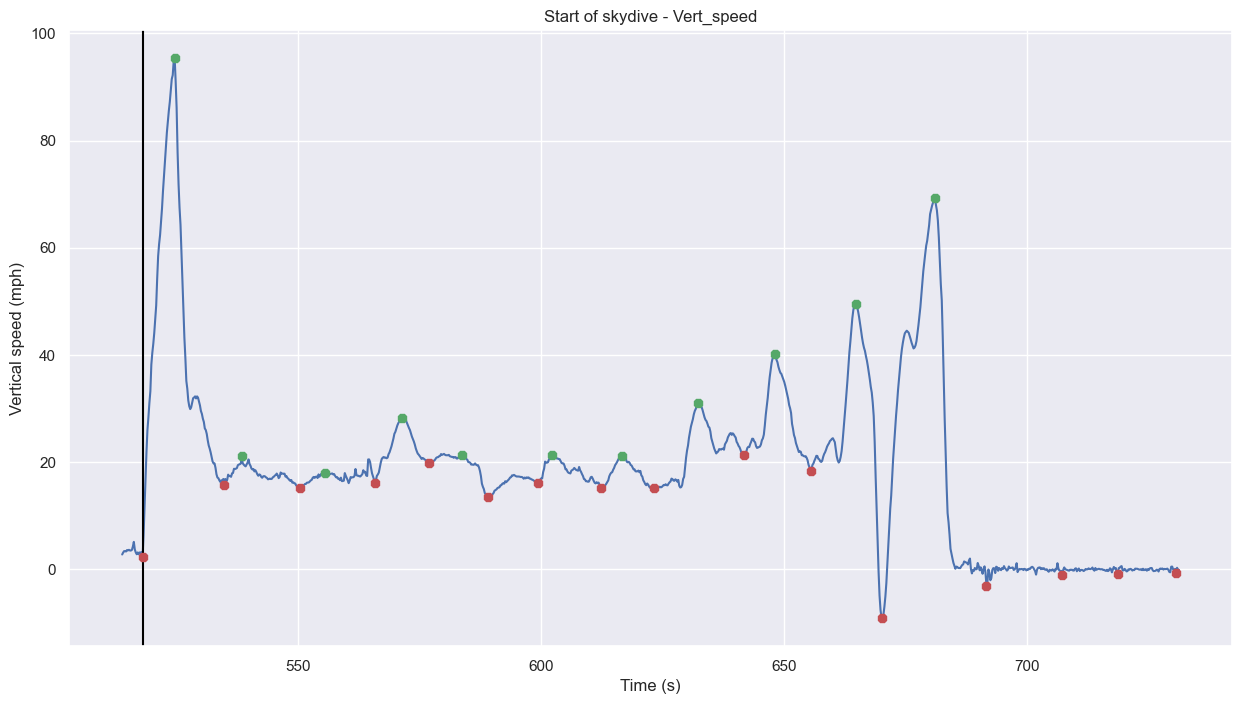

key: 21 ; time(s): 518.0


In [81]:
def start_skydive_vert_speed(x, y):
    peaks = get_peaks(y, 0.15, 50)
    lows = get_lows(y, 0.1, 50)
    
    plt.figure(figsize=(15,8))    
    plt.plot(x, y)
    plt.axvline(x = x[lows[0]], color = 'black', label = 'axvline - full height')
    plt.plot(x[peaks], y[peaks], marker="8", color='g', ls="")
    plt.plot(x[lows], y[lows], marker="8", color='r', ls="")
    plt.title("Start of skydive - Vert_speed")
    plt.xlabel("Time (s)")
    plt.ylabel("Vertical speed (mph)")
    plt.show()
    
    print(f'key: {lows[0]} ; time(s): {x[lows[0]]}')
    
start_skydive_vert_speed(jmp_df.time, jmp_df.vert_speed_mph)

In [748]:
def get_landing():
    max_id = df.fixed_elevation.idxmax()
    start_of_jump = df.iloc[max_id:]
    return start_of_jump.loc[start_of_jump.fixed_elevation <= 1200]

In [749]:
def get_max_horizontal_speed(dataframe):
    return [dataframe.horizontal_speed.idxmax(), dataframe.horizontal_speed.max()]

get_max_horizontal_speed(get_landing())

[7259, 60.776382007128724]

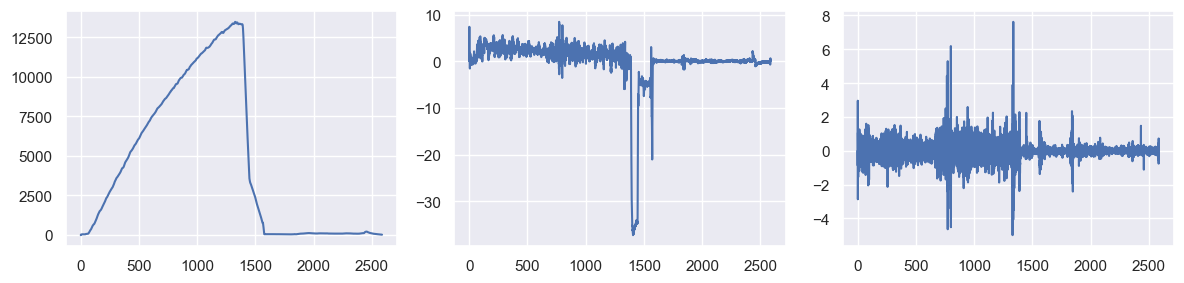

In [700]:
def plot_diff(x, y):
    ### First and second derivative ###
    diff1 = np.insert(np.diff(y), 0, 0)
    diff2 = np.insert(np.diff(diff1), 0, 0)

    ### Plot everything ###
    plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.plot(x, y)
    plt.subplot(132)
    plt.plot(x, diff1)
    plt.subplot(133)
    plt.plot(x, diff2)
    plt.tight_layout()
    
plot_diff(df.time, df.fixed_elevation)

## Visualisations

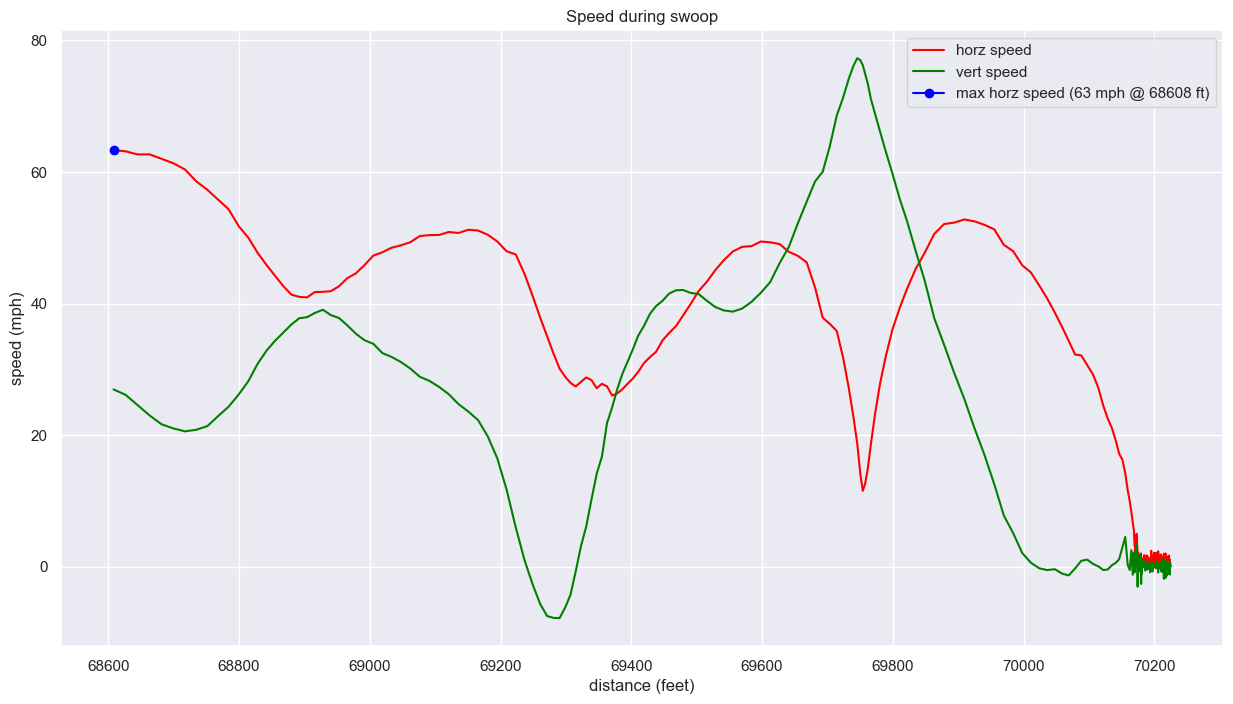

In [376]:
# Speed during swoop
landing = get_landing()
landing = landing.reset_index()

def plot_speed_during_swoop(dataframe):
    max_id = get_max_horizontal_speed(dataframe)[0]
    max_horz_distance = dataframe.horizontal_distance[max_id]
    max_horz_speed = dataframe.horizontal_speed[max_id]

    plt.figure(figsize=(15,8))
    plt.title("Speed during swoop")
    plt.plot(dataframe.horizontal_distance.iloc[max_id:], dataframe.horizontal_speed.iloc[max_id:], color='red', label='horz speed')
    plt.plot(dataframe.horizontal_distance.iloc[max_id:], dataframe.vertical_speed.iloc[max_id:], color='green', label='vert speed')
    plt.plot(max_horz_distance, max_horz_speed, 
             marker="o", color='blue', label=f"max horz speed ({round(max_horz_speed)} mph @ {round(max_horz_distance)} ft)")
    plt.legend()   
    plt.xlabel("distance (feet)")
    plt.ylabel("speed (mph)")
    plt.show()
    
plot_speed_during_swoop(landing)

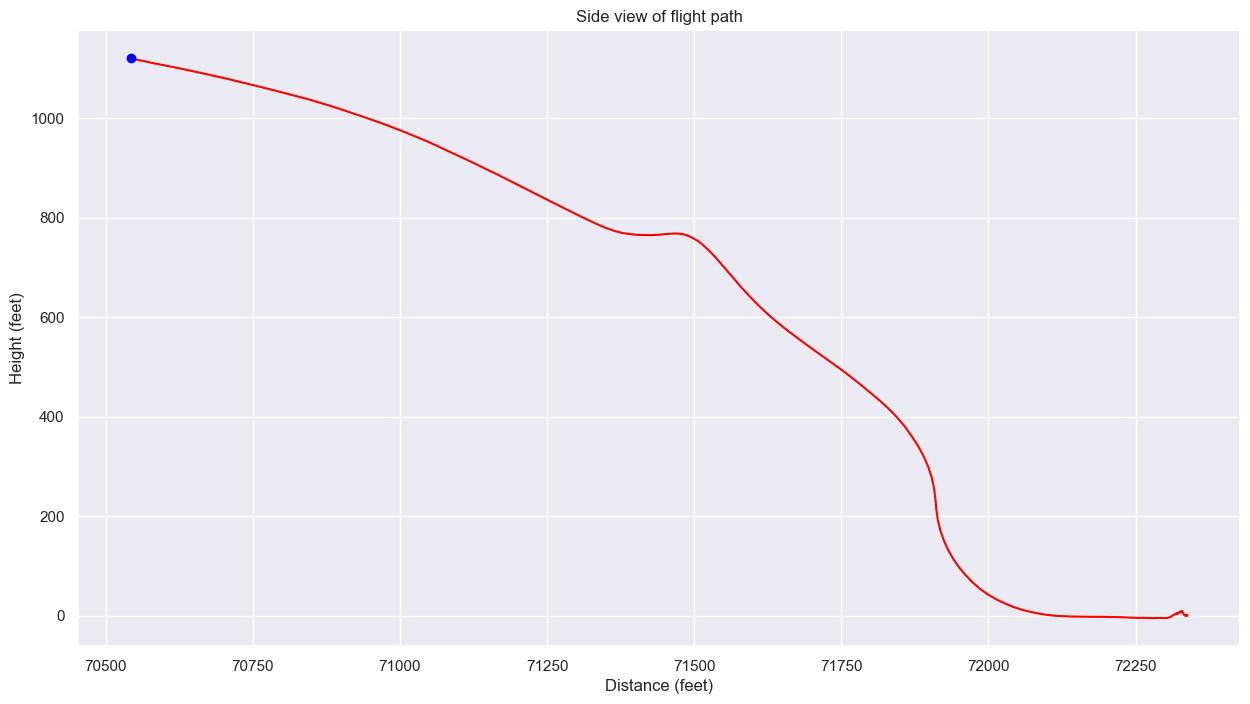

In [21]:
# Side view of flight path
def side_flight_path(dataframe):
    max_id = get_max_horizontal_speed(dataframe)[0]
    max_horz_distance = dataframe.horizontal_distance[max_id]

    plt.figure(figsize=(15,8))
    plt.title("Side view of flight path")
    plt.plot(dataframe.horizontal_distance.iloc[max_id:], dataframe.fixed_elevation[max_id:], color='red')
    plt.plot(dataframe.horizontal_distance[max_id], dataframe.fixed_elevation[max_id], marker="o", color='blue')
    plt.xlabel("Distance (feet)")
    plt.ylabel("Height (feet)")
    plt.show()
    
side_flight_path(landing)

In [750]:
fig = px.line(df, x="time", y="fixed_elevation")
fig.update_traces(mode="lines")
fig.update_xaxes(showspikes=True, spikecolor="black", spikethickness=0.5)
fig.update_yaxes(showspikes=True, spikecolor="black", spikethickness=0.5)
fig.show()

In [24]:
token = "pk.eyJ1IjoiYWlieWJydW0iLCJhIjoiY2xhdmRldnhyMDRkNTNybWg0NTl6eHgwZSJ9.phqQCg9UWIXx5wFkc_i0kg"

fig = px.line_mapbox(df, lat="lat", lon="lon", zoom=12)
fig.update_layout(mapbox_style="satellite-streets", mapbox_accesstoken=token)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()